# PyGIMLi - ERT

Using the ERT (Electrical Resistivity Tomography) solver implemented provided by [PyGIMLi](https://www.pygimli.org/), 
we use different `cofi` solvers to solve the corresponding inverse problem.

<!--<badge>--><a href="https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/notebooks/pygimli_ert/pygimli_ert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

## 0. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi

# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !mamba install -c gimli pygimli=1.3

In [2]:
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/notebooks/pygimli_ert

We will need the following packages:

- `numpy` for matrices and matrix-related functions
- `matplotlib` for plotting
- `pygimli` for forward modelling of the problem
- `cofi` for accessing different inference solvers

Additionally, we wrap some `pygimli` code in file `pygimli_ert_lib.py` and import it
here for conciseness.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli
from pygimli.physics import ert

from cofi import BaseProblem, InversionOptions, Inversion
from cofi.solvers import BaseSolver

from pygimli_ert_lib import *

np.random.seed(42)

## 1. Define the problem

We first define the true model, the survey and map it on a computational mesh designed for the survey and true anomaly.

Text(0.5, 1.0, 'True model')

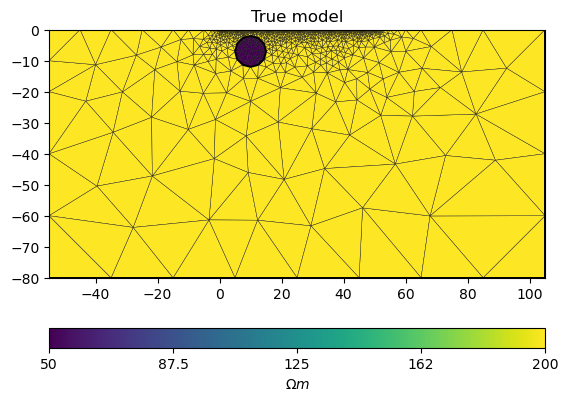

In [4]:
# PyGIMLi - define measuring scheme, geometry, forward mesh and true model
scheme = survey_scheme()
mesh, rhomap = model_true(scheme)

# plot the true model
ax = pygimli.show(mesh, data=rhomap, label="$\Omega m$", showMesh=True)
ax[0].set_title("True model")

Generate the synthetic data as a container with all the necessary information for plotting.

In ERT problems, the model and data are by convention treated in log space. 

13/10/22 - 15:52:16 - pyGIMLi - INFO - Calculate geometric factors.


ModellingBase::setMesh() copying new mesh ... Found datafile: 51 electrodes
Found: 51 free-electrodes
rMin = 0.5, rMax = 100
NGauLeg + NGauLag for inverse Fouriertransformation: 13 + 4
Found non-Neumann domain
0.012 s
FOP updating mesh dependencies ... 0 s
Obtaining geometric factors (analytical)
relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.010009229451098493 : 0.22552739004919173
Calculating response for model: min = 50 max = 200
Allocating memory for primary potential...... 0.003

No primary potential for secondary field calculation. Calculating analytically...
Factorize (Cholmod) matrix ... 0.005
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.005
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.005
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.004
Factoriz

Text(0.5, 1.0, 'Provided data')

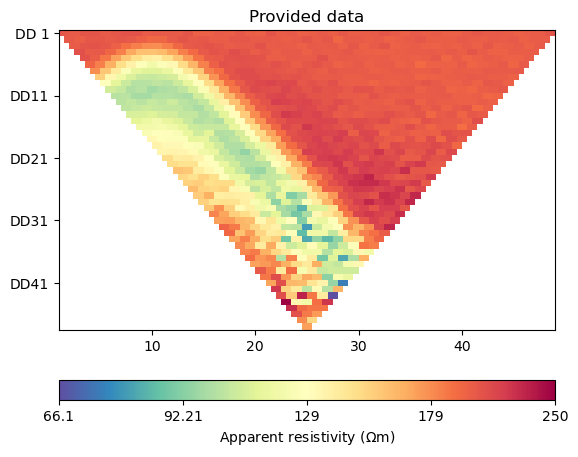

In [5]:
# PyGIMLi - generate data
data, log_data, data_cov_inv = ert_simulate(mesh, scheme, rhomap)

ax = ert.show(data)
ax[0].set_title("Provided data")

Further, we create a `pygimli.ert.ERTManager` instance to keep record of problem-specific
information like the inversion mesh, and to perform forward operation for the inversion
solvers.

In [6]:
# create PyGIMLi's ERT manager
ert_manager = ert_manager(data)

The inversion can use a different mesh and the mesh to be used should know nothing about the mesh that was designed based on the true model. We wrap two kinds of mesh as examples in the library code `pygimli_ert_lib.py`, namely triangular and rectangular mesh.

Use `imesh_tri = inversion_mesh(scheme)` to initialise a triangular mesh. This function uses PyGIMLi's own mesh generator
and generates triangular mesh automatically from given sensor locations. The resulting mesh will have a smaller area as 
unknowns to be inverted, as well as a background part with values prolongated outside from the parametric domain by PyGIMLi.
You will see an example plot in the code cell below. 

Use `imesh_rect = inversion_mesh_rect(ert_manager)` to initislise a rectangular mesh. The grid mesh is created from these x and y
nodes: `x = np.linspace(start=-5, stop=55, num=61)`, and `y = np.linspace(start=-20,stop=0,num=10)`. And again, there's a triangular
background with values prolongated outside from the parametric domain by PyGIMLi.

Here we first demonstrate how to use a *triangular mesh*. Note that this makes the inversion problem under-determined.

13/10/22 - 15:52:17 - pyGIMLi - INFO - Found 2 regions.


13/10/22 - 15:52:17 - pyGIMLi - INFO - Region with smallest marker (1) set to background


Text(0.5, 1.0, 'Mesh used for inversion')

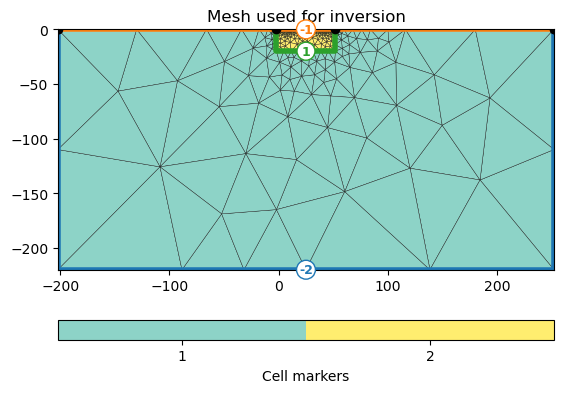

In [7]:
inv_mesh = inversion_mesh(ert_manager)
ax = pygimli.show(inv_mesh, showMesh=True, markers=True)
ax[0].set_title("Mesh used for inversion")

[This folder](https://github.com/inlab-geo/cofi-examples/tree/main/notebooks/pygimli_ert)
contains examples scripts that run inversion for triangular or rectangular meshes, with 
different inversion approaches.

With the inversion mesh created, we now define a starting model, forward operator and 
weighting matrix for regularization using PyGIMLi.

Recall that both our model and data will be in log space when we perform inversion.

13/10/22 - 15:52:17 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.


13/10/22 - 15:52:17 - Core - WARNING - Region Nr: 1  is background and should not get a model control.


13/10/22 - 15:52:17 - pyGIMLi - INFO - Creating forward mesh from region infos.


13/10/22 - 15:52:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Text(0.5, 1.0, 'Starting model')

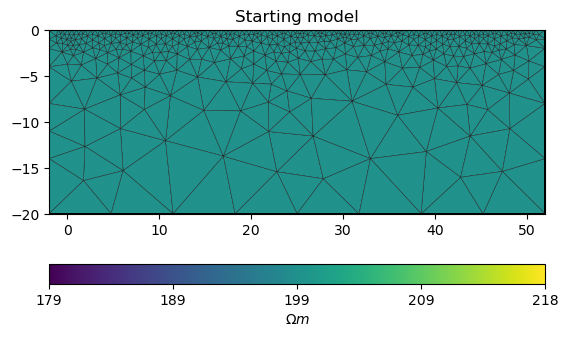

In [8]:
# PyGIMLi's forward operator (ERTModelling)
forward_oprt = ert_forward_operator(ert_manager, scheme, inv_mesh)

# extract regularization matrix
Wm = reg_matrix(forward_oprt)

# initialise a starting model for inversion
start_model, start_model_log = starting_model(ert_manager)
ax = pygimli.show(ert_manager.paraDomain, data=start_model, label="$\Omega m$", showMesh=True)
ax[0].set_title("Starting model")

CoFI and other inference packages require a set of functions that provide the misfit, the jacobian the residual within the case of scipy standardised interfaces. All these functions are defined in the library file `pygimli_ert_lib.py`, so open this file if you'd like to find out the details. These functions are:

- `get_response`
- `get_jacobian`
- `get_residuals`
- `get_data_misfit`
- `get_regularization`
- `get_gradient`
- `get_hessian`

With all the above forward operations set up with PyGIMLi, we now define the problem in `cofi`
by setting the problem information for a `BaseProblem` object.

In [9]:
# hyperparameters
lamda = 0.0001

# CoFI - define BaseProblem
ert_problem = BaseProblem()
ert_problem.name = "Electrical Resistivity Tomography defined through PyGIMLi"
ert_problem.set_forward(get_response, args=[forward_oprt])
ert_problem.set_jacobian(get_jacobian, args=[forward_oprt])
ert_problem.set_residual(get_residual, args=[log_data, forward_oprt])
ert_problem.set_data_misfit(get_data_misfit, args=[log_data, forward_oprt, data_cov_inv])
ert_problem.set_regularization(get_regularization, args=[Wm, lamda])
ert_problem.set_gradient(get_gradient, args=[log_data, forward_oprt, Wm, lamda, data_cov_inv])
ert_problem.set_hessian(get_hessian, args=[log_data, forward_oprt, Wm, lamda, data_cov_inv])
ert_problem.set_initial_model(start_model_log)

Review what information is included in the `BaseProblem` object:

In [10]:
ert_problem.summary()

Summary for inversion problem: Electrical Resistivity Tomography defined through PyGIMLi
Model shape: (831,)
----------------------------------------------------------------------------------------
List of functions/properties set by you:
['gradient', 'hessian', 'residual', 'jacobian', 'data_misfit', 'regularization', 'regularization_factor', 'forward', 'initial_model', 'model_shape']
----------------------------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['objective', 'hessian_times_vector', 'jacobian_times_vector']
----------------------------------------------------------------------------------------
List of functions/properties not set by you:
['objective', 'log_posterior', 'log_posterior_with_blobs', 'log_likelihood', 'log_prior', 'hessian_times_vector', 'jacobian_times_vector', 'regularization_matrix', 'data', 'data_covariance', 'data_covariance_inv', 'walkers_starting_pos', 'blobs_dtype', 'bo

## 2. Define the inversion options and run

### SciPy's optimizer ([trust-exact](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-trustexact.html#optimize-minimize-trustexact))

In [11]:
ert_problem.suggest_solvers();

Based on what you've provided so far, here are possible solvers:
{
    "optimization": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares"
    ],
    "matrix solvers": [
        "cofi.simple_newton"
    ],
    "sampling": []
}


In [12]:
inv_options_scipy = InversionOptions()
inv_options_scipy.set_tool("scipy.optimize.minimize")
inv_options_scipy.set_params(method="trust-exact", options={"maxiter": 10})

Review what's been defined for the inversion we are about to run:

In [13]:
inv_options_scipy.summary()

Summary for inversion options
Solving method: None set
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `scipy.optimize.minimize` - SciPy's optimizers that minimizes a scalar function with respect to one or more variables, check SciPy's documentation page for a list of methods
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: 
method = trust-exact
options = {'maxiter': 10}
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


In [14]:
inv = Inversion(ert_problem, inv_options_scipy)
inv_result = inv.run()
# inv_result.summary()
print(f"\nSolver message: {inv_result.message}")

/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.10/site-packages/scipy/optimize/_minimize.py:561: RuntimeWarning: Method trust-exact does not use Hessian-vector product information (hessp).
  warn('Method %s does not use Hessian-vector product '



Solver message: Maximum number of iterations has been exceeded.


In [15]:
inv_result.success

False

Plot the results:

Text(0.5, 1.0, 'Inferred model')

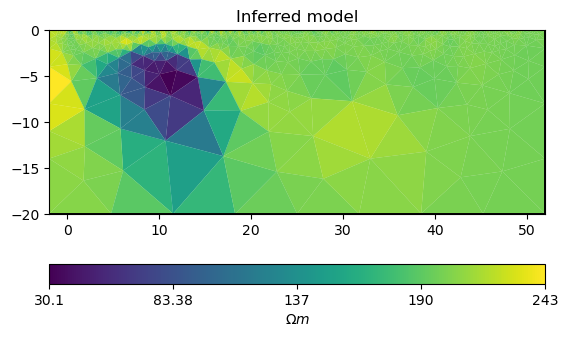

In [16]:
# convert back to normal space from log space
model = np.exp(inv_result.model)

# plot inferred model
ax = pygimli.show(ert_manager.paraDomain, data=model, label=r"$\Omega m$")
ax[0].set_title("Inferred model")

We can now also compare the synthetic data with provided observations.

Text(0.5, 1.0, 'Provided data')

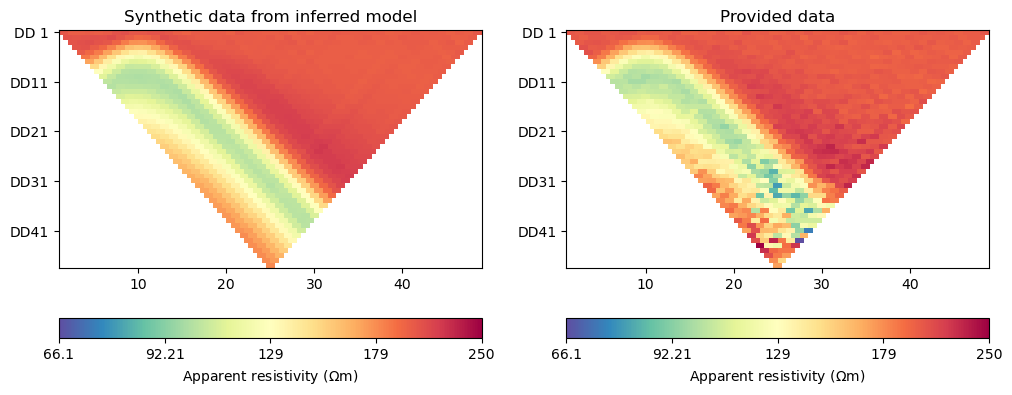

In [17]:
_, axes = plt.subplots(1, 2, figsize=(12,4))

# plot synthetic data
d = forward_oprt.response(model)
ert.showERTData(scheme, vals=d, cMin=np.min(data["rhoa"]), cMax=np.max(data["rhoa"]), ax=axes[0])
axes[0].set_title("Synthetic data from inferred model")

# plot given data
ert.show(data, ax=axes[1])
axes[1].set_title("Provided data")

## 3. What's next?

Now that we've seen the PyGIMLi ERT problem solved by two different inversion approaches through CoFI,
it would be nice to see more inversion solvers (even a sampler!) and a similar problem
defined with a rectangular mesh. If you'd like to see some self-contained examples, head to
[this GitHub folder](https://github.com/inlab-geo/cofi-examples/tree/main/notebooks/pygimli_ert)
to explore more.

<!-- ### 2.3 Bayesian sampling with emcee (exploration)

CoFI needs more assumptions about the problem for a sampler to work - these are
the log of posterior distribution density and walkers' starting positions.

For the log posterior, we define here by specifying `log_prior` and `log_likelihood`.
And CoFI will combine them to get the `log_posterior`. -->

---
## Watermark

In [18]:
watermark_list = ["cofi", "numpy", "scipy", "pygimli", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.1.2.dev13
numpy 1.21.6
scipy 1.9.1
pygimli 1.2.6
matplotlib 3.5.3
